In [165]:
import nltk
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from gensim.models import FastText
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics.pairwise import cosine_similarity

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mgrapotte/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mgrapotte/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [208]:
deck = pd.read_csv("parser_output/Juri_example_output_from_parser.csv")

In [209]:
deck_without_land = deck[deck["type"]!="['Land']"]

In [8]:
stop_words = nltk.corpus.stopwords.words('english')

In [17]:
def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s-]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = nltk.word_tokenize(doc)
    #filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

In [53]:
normalize_corpus = np.vectorize(normalize_document)

norm_corpus = normalize_corpus(list(deck_without_land['text']))
len(norm_corpus)

66

In [73]:
tokenized_docs = [doc.split() for doc in norm_corpus]
ft_model = FastText(tokenized_docs, window=100, min_count=1, workers=4, sg=1)

In [74]:
def averaged_word2vec_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index_to_key)
    
    def average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        nwords = 0.
        
        for word in words:
            if word in vocabulary: 
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model.wv[word])
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)

        return feature_vector

    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [75]:
doc_vecs_ft = averaged_word2vec_vectorizer(tokenized_docs, ft_model, 100)
doc_vecs_ft.shape

(66, 100)

In [76]:
def ward_hierarchical_clustering(feature_matrix):
    
    cosine_distance = 1 - cosine_similarity(feature_matrix)
    linkage_matrix = ward(cosine_distance)
    return linkage_matrix

In [77]:
def plot_hierarchical_clusters(linkage_matrix, deck_data, p=100, figure_size=(8,12)):
    # set size
    fig, ax = plt.subplots(figsize=figure_size) 
    card_names = deck_data['name'].values.tolist()
    # plot dendrogram
    R = dendrogram(linkage_matrix, orientation="left", labels=card_names,
                    truncate_mode='lastp', 
                    p=p,  
                    no_plot=True)
    temp = {R["leaves"][ii]: card_names[ii] for ii in range(len(R["leaves"]))}
    def llf(xx):
        return "{}".format(temp[xx])
    ax = dendrogram(
            linkage_matrix,
            truncate_mode='lastp',
            orientation="left",
            p=p,  
            leaf_label_func=llf, 
            leaf_font_size=10.,
            )
    plt.tick_params(axis= 'x',   
                    which='both',  
                    bottom='off',
                    top='off',
                    labelbottom='off')
    plt.tight_layout()

In [78]:
linkage_matrix = ward_hierarchical_clustering(doc_vecs_ft)

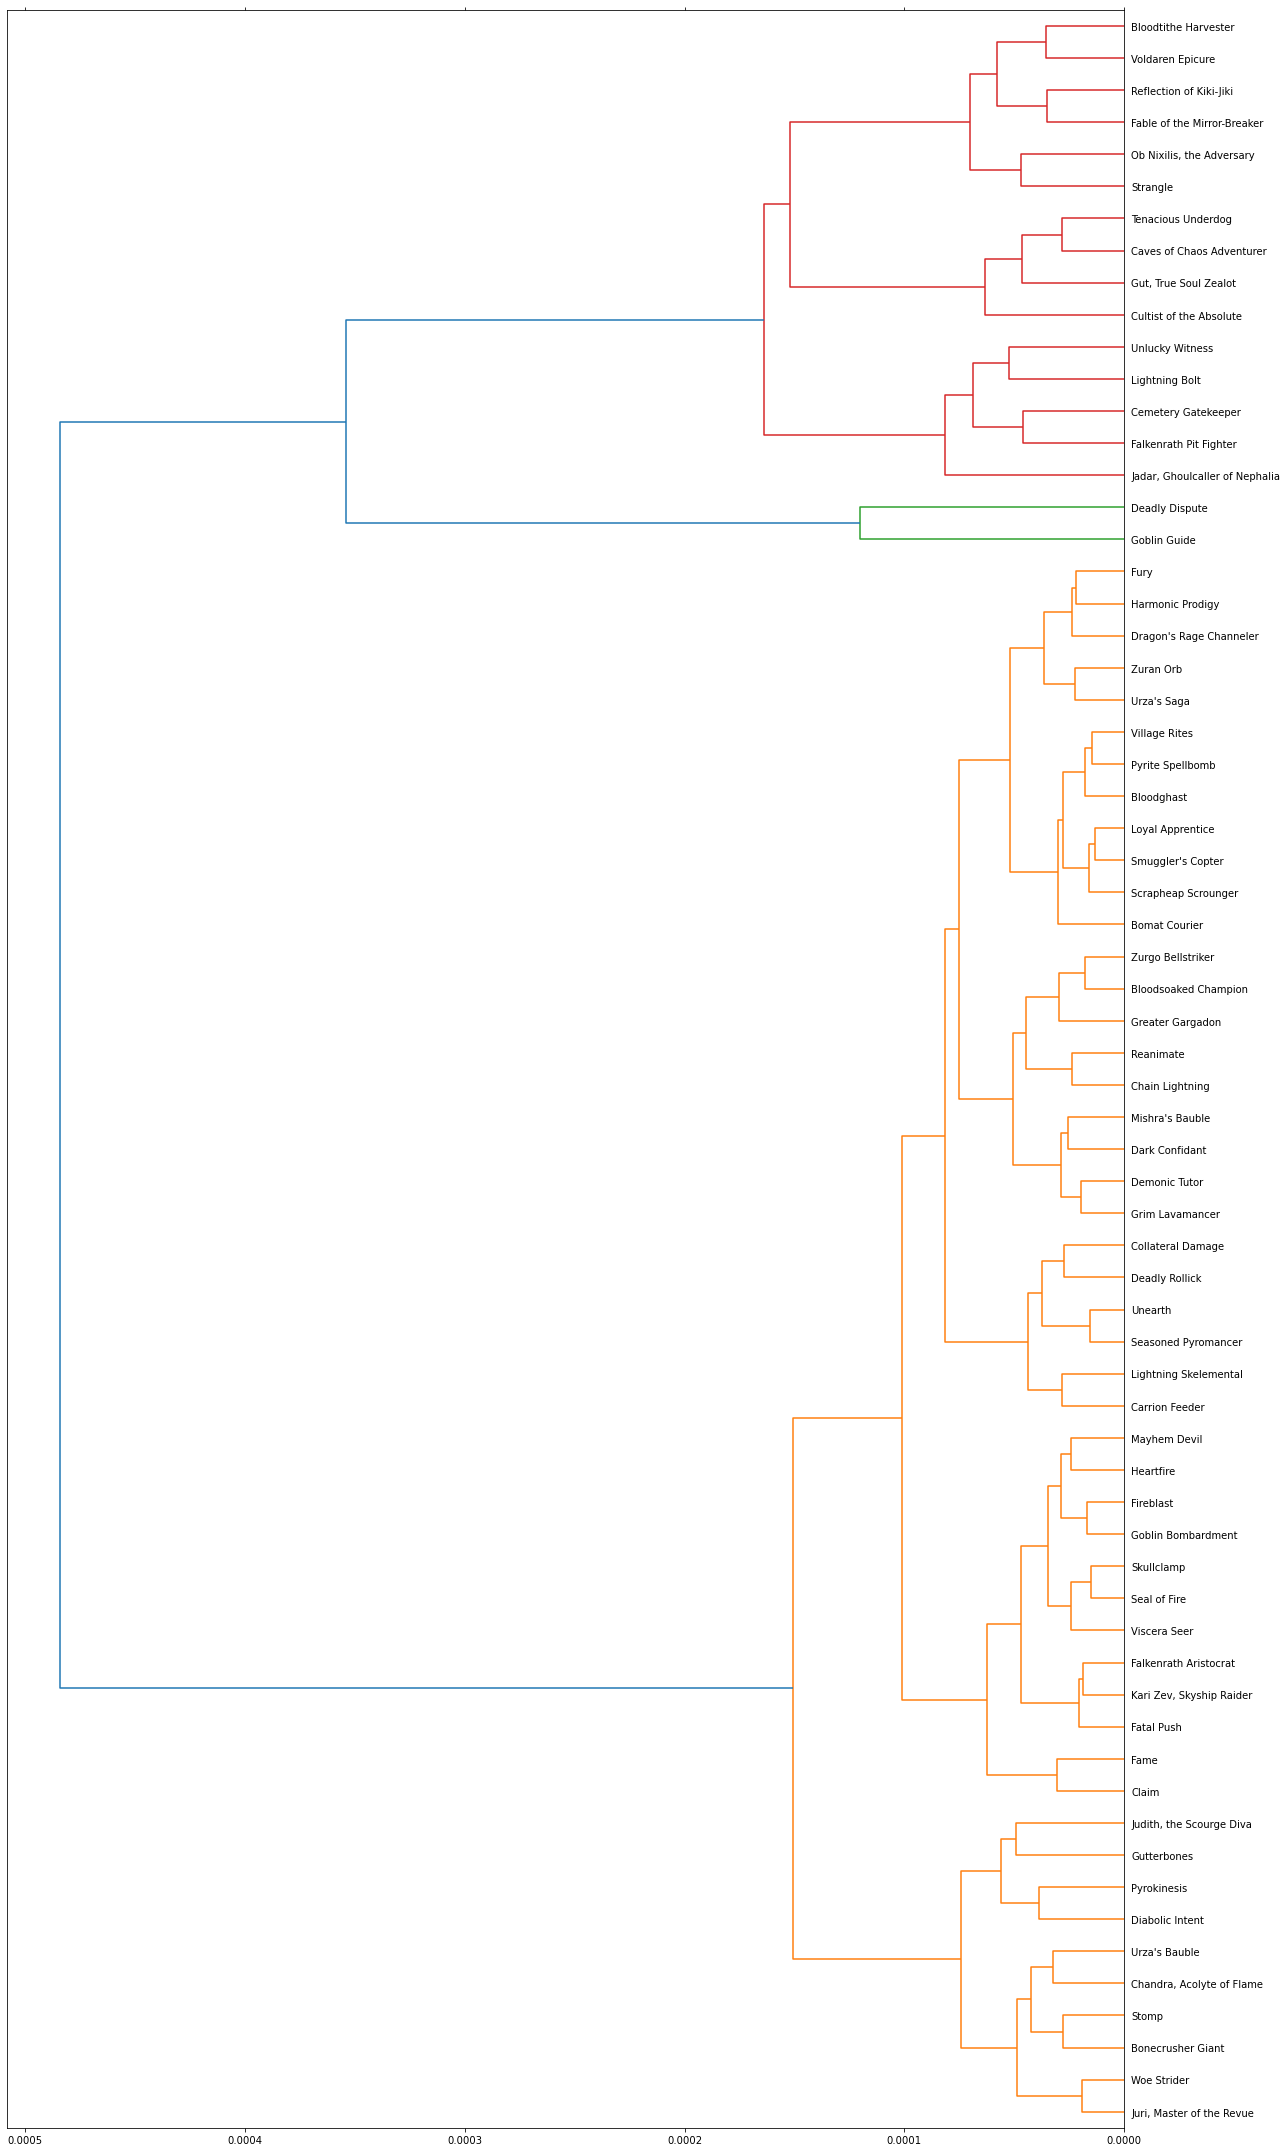

In [79]:
plot_hierarchical_clusters(linkage_matrix,
                           p=200,
                           deck_data=deck_without_land,
                           figure_size=(18, 30))

### LDA 

In [210]:
from wordcloud import WordCloud
from gensim.utils import simple_preprocess
import gensim.corpora as corpora

import gensim

In [211]:
stop_words.extend(['creature','card','cards','may','target','battlefield','hand','spell'])

In [212]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

In [213]:
long_string = ','.join(norm_corpus)

In [214]:
wordcloud.generate(long_string)

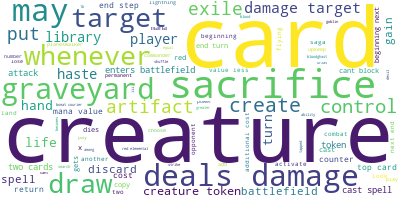

In [215]:
wordcloud.to_image()

In [216]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [217]:
data = deck_without_land.text.values.tolist()
data_words = list(sent_to_words(data))# remove stop words
data_words = remove_stopwords(data_words)

In [218]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)# Create Corpus
texts = data_words# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1)]


In [219]:
from pprint import pprint# number of topics
num_topics = 4# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.030*"sacrifice" + 0.024*"draw" + 0.024*"whenever" + 0.023*"artifact" + '
  '0.021*"turn" + 0.020*"control" + 0.019*"haste" + 0.016*"end" + '
  '0.016*"discard" + 0.015*"token"'),
 (1,
  '0.029*"sacrifice" + 0.025*"put" + 0.025*"library" + 0.021*"beginning" + '
  '0.020*"control" + 0.020*"life" + 0.018*"copy" + 0.018*"player" + '
  '0.017*"top" + 0.016*"create"'),
 (2,
  '0.054*"sacrifice" + 0.030*"cast" + 0.027*"artifact" + 0.026*"cost" + '
  '0.025*"additional" + 0.018*"token" + 0.017*"create" + 0.016*"draw" + '
  '0.015*"put" + 0.015*"two"'),
 (3,
  '0.042*"damage" + 0.037*"deals" + 0.031*"graveyard" + 0.027*"exile" + '
  '0.020*"turn" + 0.019*"mana" + 0.019*"sacrifice" + 0.019*"two" + '
  '0.019*"enters" + 0.017*"whenever"')]


In [220]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis# Visualize the topics
import os
pyLDAvis.enable_notebook()


LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)


/Users/mgrapotte/opt/anaconda3/envs/mtg/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [221]:
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.060333 -0.053638       1        1  37.477857
3      0.108454 -0.014480       2        1  30.517780
1     -0.024451  0.068210       3        1  23.864475
2     -0.023670 -0.000092       4        1   8.139888, topic_info=           Term       Freq      Total Category  logprob  loglift
11    sacrifice  25.000000  25.000000  Default  30.0000  30.0000
155    artifact  11.000000  11.000000  Default  29.0000  29.0000
14         cast  11.000000  11.000000  Default  28.0000  28.0000
15         cost   9.000000   9.000000  Default  27.0000  27.0000
64   additional   4.000000   4.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
39      control   0.807764  13.026322   Topic4  -4.5174  -0.2721
48         mana   0.692475  10.150013   Topic4  -4.6714  -0.1766
65      library   0.674662  10.080918   Topic4  -4.6975  -0.1958
96      attacks   0.567837   7.142721   Topic4  -4.8699  -0.0236
2         deals   0.577704  16.676286   Topic4  -4.8526  -0.8543

[255 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
209       1  0.603620   ability
76        1  0.596328  activate
76        2  0.198776  activate
195       1  0.549824       add
195       4  0.274912       add
...     ...       ...       ...
238       3  0.668155   witness
30        2  0.486395       woe
56        3  0.672083     would
107       2  0.687042       zev
171       1  0.596386     zurgo

[278 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3])